In [79]:
require(data.table)
require(ggplot2)
require(viridis)
require(RColorBrewer)
source("functions/save_and_plot.R")

In [80]:
pdata = fread("../data/Tier_2_detection_efficiency_per_replicate_chrX_46plex_eLIT.csv")[, V1 := NULL]

In [81]:
dim(pdata)

[1] 336   6

In [82]:
head(pdata)

image,roi,category,Deconvolution,detected,match_barcodes
<int>,<int>,<chr>,<chr>,<dbl>,<int>
1,3,OFQv68_w2,DW,0.9565217,44
1,4,OFQv68_w2,DW,0.9130435,42
1,5,OFQv68_w2,DW,1.0000000,46
1,6,OFQv68_w2,DW,0.9565217,44
1,7,OFQv68_w2,DW,0.9565217,44
1,8,OFQv68_w2,DW,1.0000000,46


In [83]:
pdata[, unique(image)]

[1]  1  2  3  4  5  6  7  8  9 10 21 23 24 25 11 12 13 14 15 31 32 33 34 35

In [84]:
pdata[, unique(roi)]

[1]  3  4  5  6  7  8  9  2  1 10 11 12 13

In [85]:
pdata[, unique(category)]

[1] "OFQv68_w2"    "OFQv68_w3"    "OFQv68_w3_BS" "OFQv68_w4"    "OFQv68_w4_BS"
[6] "OFQv69_w4"    "OFQv69_w5"

In [86]:
pdata[, .N, by=category]

category,N
<chr>,<int>
OFQv68_w2,64
OFQv68_w3,42
OFQv68_w3_BS,34
OFQv68_w4,64
OFQv68_w4_BS,34
OFQv69_w4,54
OFQv69_w5,44


In [87]:
pdata[, .N, by=c("category", "Deconvolution")]

category,Deconvolution,N
<chr>,<chr>,<int>
OFQv68_w2,DW,32
OFQv68_w3,DW,21
OFQv68_w3_BS,DW,17
OFQv68_w4,DW,32
OFQv68_w4_BS,DW,17
OFQv69_w4,DW,27
OFQv69_w5,DW,22
OFQv68_w2,Non DW,32
OFQv68_w3,Non DW,21


In [88]:
set.seed(465456)
pdata[Deconvolution == "Non DW", Deconvolution := "RL"]
pdata[, Deconvolution := factor(Deconvolution, levels=c("RL", "DW"))]
pdata[, category := factor(category, levels=c("OFQv68_w2", "OFQv68_w3", "OFQv68_w4", "OFQv68_w3_BS", "OFQv68_w4_BS", "OFQv69_w4", "OFQv69_w5"))]
pdata[, nudge_x := runif(.N, -.125, .125)]

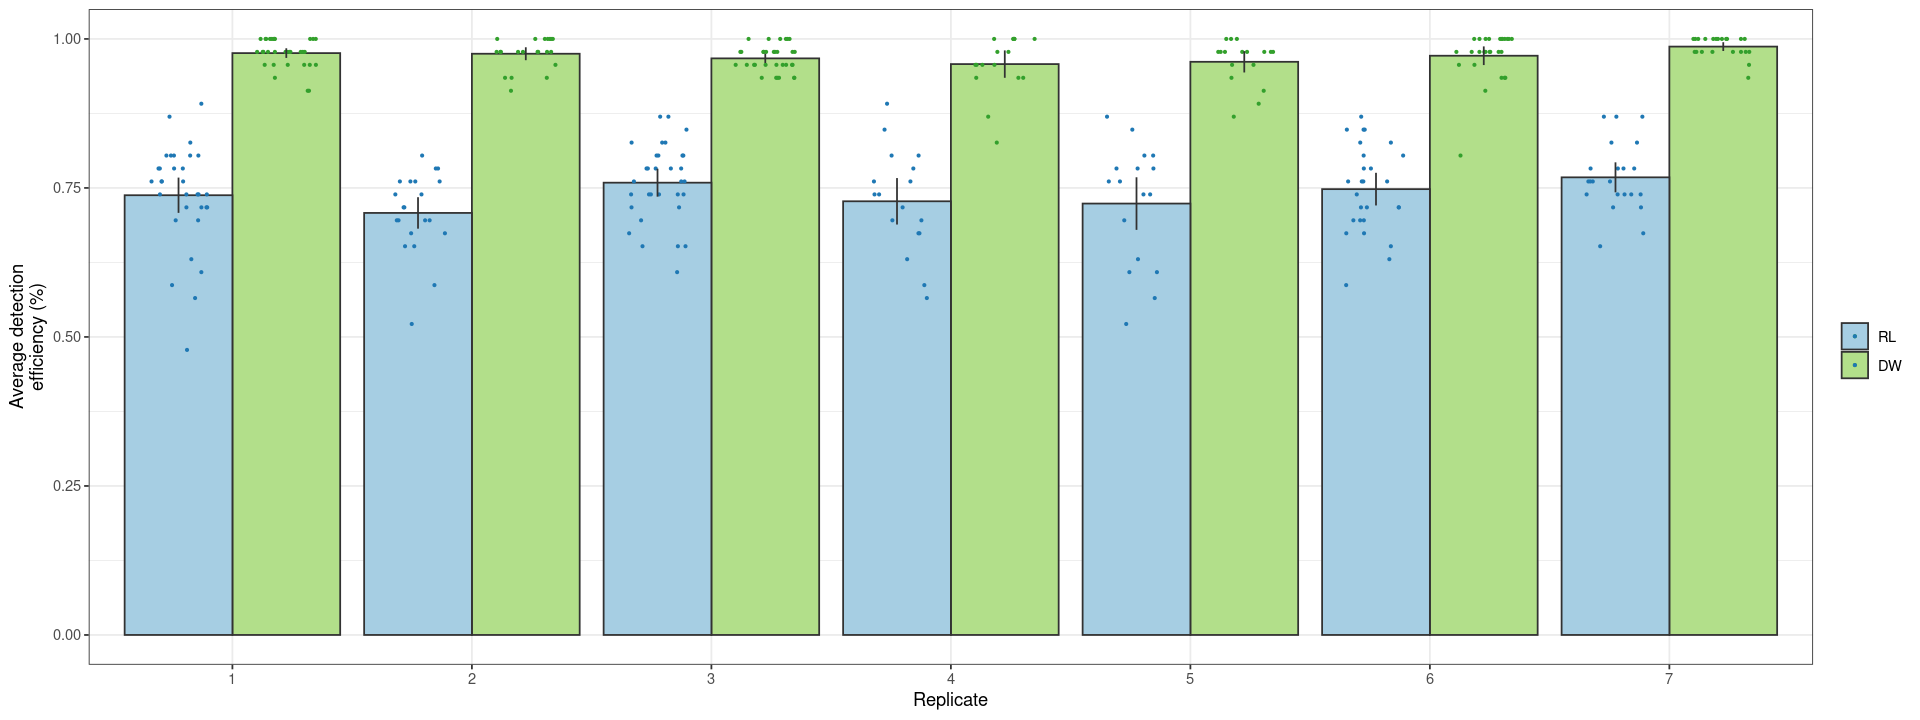

In [89]:
options(repr.plot.width=16, repr.plot.height=6)
palette = brewer.pal(4, "Paired")

require(boot)
set.seed(424654)
mean.fun = function(data, idx) { mean(data[idx]) }
stat_data = pdata[, .(mean=mean(detected), sd=sd(detected), ci=diff(unlist(boot.ci(boot.out=boot(detected, mean.fun, R=1000), type=c("perc"))$percent)[4:5])/2), by=c("category", "Deconvolution")]

p = ggplot(stat_data, aes(x=factor(category), y=mean, fill=Deconvolution)) +
    geom_col(position="dodge", color="#323232") +
    theme_bw() + scale_fill_manual("", values=palette[c(1,3)]) +
    scale_x_discrete(labels=1:7) + labs(x="Replicate", y="Average detection\nefficiency (%)") +
    geom_point(data=pdata[Deconvolution == "DW"],
               aes(x=as.numeric(factor(category))+.225+nudge_x, y=detected),
               color=palette[4], size=.5) +
    geom_point(data=pdata[Deconvolution == "RL"],
               aes(x=as.numeric(factor(category))-.225+nudge_x, y=detected),
               color=palette[2], size=.5) +
    geom_errorbar(data=stat_data[Deconvolution == "DW"],
                  aes(x=as.numeric(factor(category))+.225, ymax=mean+ci, ymin=mean-ci),
                  color="#323232", width=0, size=.5) +
    geom_errorbar(data=stat_data[Deconvolution == "RL"],
                  aes(x=as.numeric(factor(category))-.225, ymax=mean+ci, ymin=mean-ci),
                  color="#323232", width=0, size=.5)
print(p)

In [90]:
save_and_plot(p, "panels/fig_5c", width=8, height=2.5, formats=c("png", "jpg", "pdf"))
saveRDS(p, "panels/fig_5c.rds")

In [91]:
bs = boot(pdata[Deconvolution == "DW", detected], mean.fun, R=1000)
ci = boot.ci(boot.out=bs, type=c("perc"))
sprintf("%.1f += %.1f %%", bs$t0*100, diff(unlist(ci$percent)[4:5])/2*100)

bs = boot(pdata[Deconvolution == "RL", detected], mean.fun, R=1000)
ci = boot.ci(boot.out=bs, type=c("perc"))
sprintf("%.1f += %.1f %%", bs$t0*100, diff(unlist(ci$percent)[4:5])/2*100)


[1] "97.2 += 0.5 %"

[1] "74.1 += 1.2 %"

In [92]:
stat_data = pdata[, .(mean=mean(detected), sd=sd(detected)), by=c("match_barcodes", "Deconvolution")]
head(stat_data)

match_barcodes,Deconvolution,mean,sd
<int>,<fct>,<dbl>,<dbl>
44,DW,0.9565217,0
42,DW,0.9130435,0
46,DW,1.0000000,0
45,DW,0.9782609,0
43,DW,0.9347826,0
38,DW,0.8260870,NA


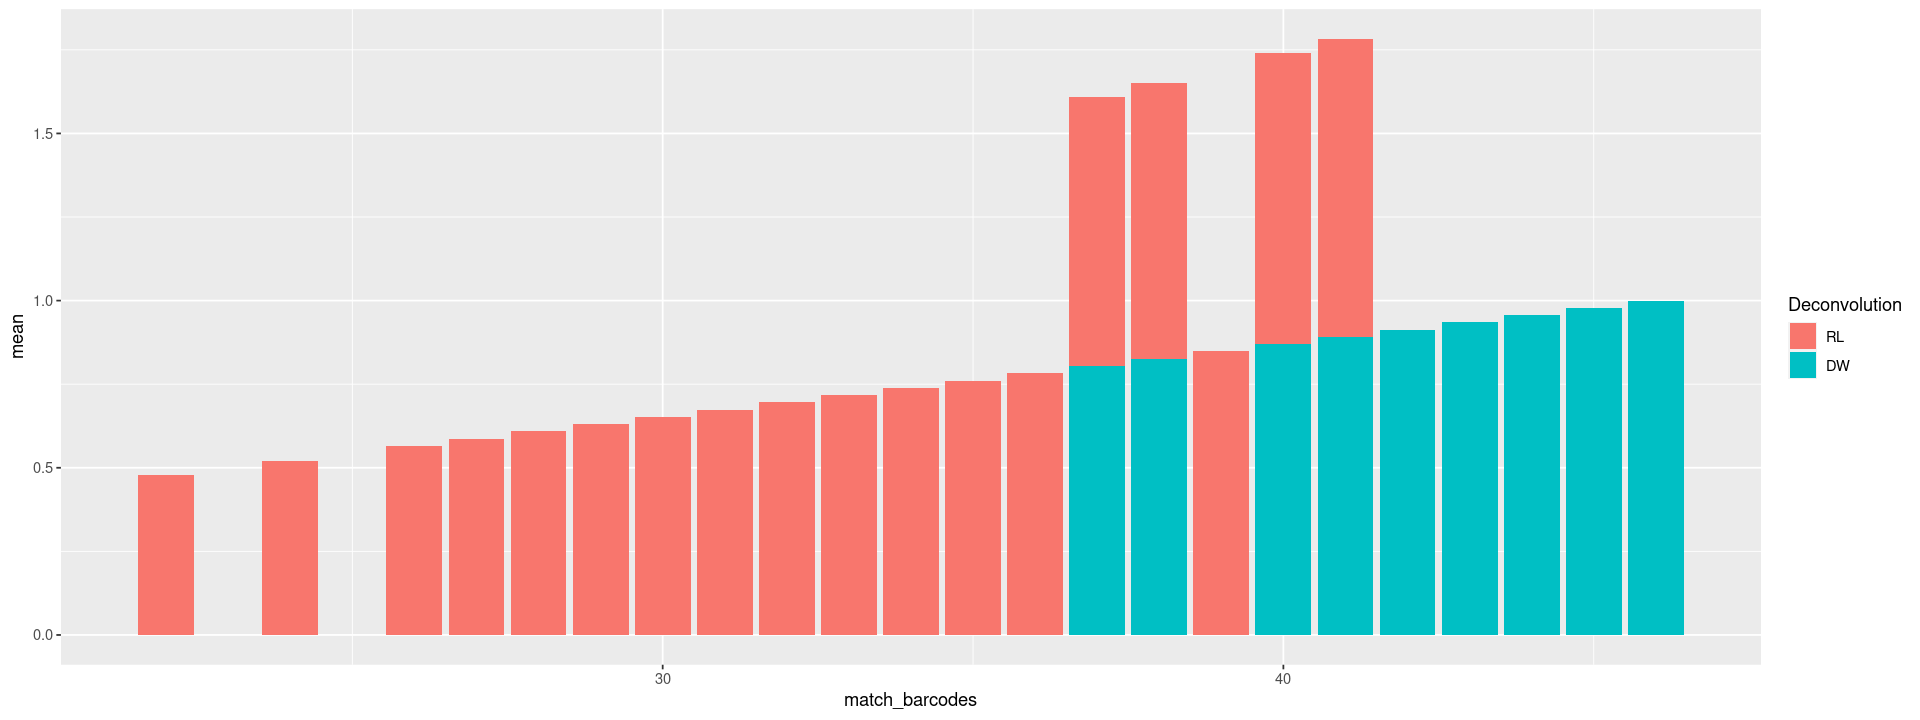

In [93]:
ggplot(stat_data, aes(x=match_barcodes, y=mean, fill=Deconvolution)) + geom_col()

In [94]:
pdata2 = fread("../data/Tier_2_detection_efficiency_per_replicate_chrX_46plex_eLIT.csv")[, V1 := NULL]

In [95]:
#pdata2[match_barcodes=="45"]
sort(pdata2[, unique(match_barcodes)])

[1] 22 24 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46

In [96]:
apply(dcast(pdata2[, .(N=1), by=c("Deconvolution", "match_barcodes")], Deconvolution~match_barcodes, value.var="N")[, 2:23], MARGIN=2, FUN=sum, na.rm=T)

22 24 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 
 1  1  1  1  1  1  1  1  1  1  1  1  1  2  2  1  2  2  1  1  1  1